# Code for sparse coding of spectrotemporal data
*Nhat Le, Sep 2017*

In [401]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.io.wavfile
import scipy.signal
import glob
import skimage.io
from sklearn.decomposition import PCA
import seaborn as sns

%matplotlib inline

In [2]:
def C_L0_norm(x):
    '''L0 norm function for each element of a vector'''
    if x != 0:
        return 0.0
    else:
        return 1.0

def C_L1_norm(x):
    '''L1 norm function for each element of a vector'''
    return abs(x)

def C_L0_norm_deriv(x):
    '''Derivative of C_L0_norm'''
    if x != 0:
        return 0.0
    else:
        return np.inf
    
def C_L1_norm(x):
    '''Derivative of C_L1_norm'''
    if x < 0:
        return -1.0
    elif x > 0:
        return 1.0
    else:
        return np.inf

In [164]:
T_vec(np.array([[-1, 1, 2, 3], [1,2,3,4]]), 0.01, 'L1')

array([[ 0.  ,  0.99,  1.99,  2.99],
       [ 0.99,  1.99,  2.99,  3.99]])

In [243]:
def T(u, lamb, norm_type):
    '''Threshold function as described'''
    if norm_type == 'L0':
        return max(u, 0.0)
    elif norm_type == 'L1':
        return max(u - lamb, 0.0)
    else:
        raise ValueError('Invalid norm type')
        
T_vec = np.vectorize(T)

def find_u_dot(tau, u, A, y, lamb):
    s = T_vec(u, lamb, 'L0')
    b = np.dot(A.T, y)
    A_shift = np.dot(A.T, A) - np.identity(A.shape[1])
    return (b - u - np.dot(A_shift, s)) / tau
    
T_vec = np.vectorize(T)

def find_s(tau, A, y, lamb, niter=100, update='paper', verbose=False):
    # Initialize
    best_cost = np.inf
    cost_prev = np.inf
    y = y[:, np.newaxis]
    s = np.zeros((A.shape[1], 1), dtype='float')
    best_s = np.zeros((A.shape[1], 1), dtype='float')
    u = np.zeros((A.shape[1], 1), dtype='float')
    for i in range(niter):
        print('Starting iteration #', i, '...')
        if update == 'direct':
            ds = np.dot(A.T, y) - np.dot(np.dot(A.T, A), s) - np.sign(s)
            s += ds * tau
        elif update == 'paper':
            du = np.dot(A.T, y) - np.dot(np.dot(A.T, A), s) - np.sign(s)
            
            u += du * tau
            print(u)
            s = T_vec(u, lamb, norm_type='L1')
            print(s)
            
        cost = 0.5 * np.linalg.norm(y - np.dot(A, s))**2 + lamb * np.linalg.norm(s, ord=1)
        if cost <= cost_prev:
            tau *= 1.05
        else:
            tau *= 0.5
        
        cost_prev = cost
            
        if cost < best_cost:
            best_cost = cost
            best_s = s
        
        if verbose:
            print('Cost = ', cost, '. tau =', tau)
    print('Best cost = ', best_cost, 'Best s =', best_s.T)
    return best_s, best_cost


def find_s_batch(tau, A, Y, lamb, niter=100, update='paper', verbose=False):
    # Initialize
    best_cost = np.inf
    cost_prev = np.inf
    S = np.zeros((A.shape[1], Y.shape[1]), dtype='float')
    best_S = np.zeros((A.shape[1], Y.shape[1]), dtype='float')
    U = np.zeros((A.shape[1], Y.shape[1]), dtype='float')
    for i in range(niter):
        print('Starting iteration #', i, '...')
        if update == 'direct':
            ds = np.dot(A.T, Y) - np.dot(np.dot(A.T, A), S) - np.sign(S)
            S += ds * tau
        elif update == 'paper':
            du = np.dot(A.T, Y) - np.dot(np.dot(A.T, A), S) - np.sign(S)
            
            U += du * tau
            
            S = T_vec(U, lamb, norm_type='L1')
            
        diff = (Y - np.dot(A, S)).ravel()
        cost = 0.5 * np.linalg.norm(diff)**2 + lamb * np.linalg.norm(S.ravel(), ord=1)
        #print('cost: ', cost)
        if cost <= cost_prev:
            tau *= 1.05
        else:
            tau *= 0.5
        
        cost_prev = cost
            
        if cost < best_cost:
            best_cost = cost
            best_S = S
        
        if verbose:
            print('Cost = ', cost, '. tau =', tau)
    print('Best cost = ', best_cost)
    return best_S

In [230]:
A = np.array([[1,3,4, 8], [4,5,6, 2], [0,8,11, 3]], dtype='float')
y1 = np.array([30, 49, 79], dtype='float')
tau = 0.1
lamb = 0.0001
v1, e1 = find_s(tau, A, y1, lamb, niter=1, update='paper')

[[  22.6]
 [  96.7]
 [ 128.3]
 [  57.5]]
[[  22.5999]
 [  96.6999]
 [ 128.2999]
 [  57.4999]]
Best cost =  4377813.34211 Best s = [[  22.5999   96.6999  128.2999   57.4999]]


In [231]:
y2 = np.array([20, 10, 60], dtype='float')
v2, e2 = find_s(tau, A, y2, lamb, niter=1, update='paper')

[[  6.]
 [ 59.]
 [ 80.]
 [ 36.]]
[[  5.9999]
 [ 58.9999]
 [ 79.9999]
 [ 35.9999]]
Best cost =  1647875.24081 Best s = [[  5.9999  58.9999  79.9999  35.9999]]


In [232]:
4377813.34211 + 1647875.24081

6025688.58292

In [233]:
Y = np.hstack((y1[:,np.newaxis], y2[:,np.newaxis]))
V = find_s_batch(tau, A, Y, lamb, niter=1, update='paper')
V

[[  22.5999    5.9999]
 [  96.6999   58.9999]
 [ 128.2999   79.9999]
 [  57.4999   35.9999]]
Best cost =  6025688.58291


array([[  22.5999,    5.9999],
       [  96.6999,   58.9999],
       [ 128.2999,   79.9999],
       [  57.4999,   35.9999]])

In [383]:
def learn_step(y, A, s, eta, theta):
    s = s[:, np.newaxis]
    y = y[:, np.newaxis]
    r = y - np.dot(A, s)
    A_new = A + eta * (np.dot(r, s.T)) + theta * (A - np.dot(A, np.dot(A.T, A)))
    #A_new /= np.linalg.norm(A_new, axis=0)
    return A_new

def learn_step_batch(Y, A, S, eta, theta):
    R = Y - np.dot(A, S)
    A_new = A + eta * (np.dot(R, S.T)) + theta * (A - np.dot(A, np.dot(A.T, A)))
    #A_new /= np.linalg.norm(A_new, axis=0)
    return A_new

def do_multiple_learn_steps(y, A, s, eta, theta, nsteps=10, verbose=False):
    prev_cost = np.inf
    best_cost = np.inf
    A_best = A
    for i in range(nsteps):
        if y.ndim == 1: # Single example
            A = learn_step(y, A, s, eta, theta)
        else: # batch
            assert(y.shape[1] == s.shape[1])
            A = learn_step_batch(y, A, s, eta, theta)
        cost = np.linalg.norm(y - np.dot(A, s))**2
        if verbose:
            #print(A[0,:])
            print('Cost = ', cost, 'eta = ', eta, 'theta = ', theta)
        if cost < best_cost:
            best_cost = cost
            A_best = A
            
        if cost <= prev_cost:
            eta *= 1.05
            theta *= 1.05
        else:
            eta *= 0.5
            theta *= 0.5
        
        prev_cost = cost
    print('Best cost = ', best_cost)
        
    return A_best

def find_optimal_A(y, s):
    assert(s.shape[1] == 1)
    y = y[:, np.newaxis]
    n = np.dot(s.T, s)[0,0]
    #print(s.shape, y.shape)
    return np.dot(y, 1.0 / n * s.T)

In [95]:
#b = np.array([1, 1, 3], dtype='float')
A = np.array([[1,3,4, 8], [4,5,6, 2], [0,8,11, 3]], dtype='float')
A = A / np.linalg.norm(A, axis=0)
s = np.array([3,3,4,5], dtype='float')
#u = np.array([5, -4, 3,0], dtype='float')
y = np.array([30, 49, 79], dtype='float')
eta = 0.001
theta = 0.0001

A_d = do_multiple_learn_steps(y, A, s, eta, theta, nsteps=100)

Cost =  6514.76286678 eta =  0.001 theta =  0.0001
Cost =  5733.79429063 eta =  0.0010500000000000002 theta =  0.000105
Cost =  5014.77551997 eta =  0.0011025000000000002 theta =  0.00011025000000000001
Cost =  4357.99198374 eta =  0.0011576250000000002 theta =  0.00011576250000000002
Cost =  3763.13944259 eta =  0.0012155062500000004 theta =  0.00012155062500000002
Cost =  3229.26586005 eta =  0.0012762815625000006 theta =  0.00012762815625000002
Cost =  2754.73659513 eta =  0.0013400956406250007 theta =  0.00013400956406250003
Cost =  2337.23003892 eta =  0.0014071004226562508 theta =  0.00014071004226562505
Cost =  1973.76899119 eta =  0.0014774554437890634 theta =  0.0001477455443789063
Cost =  1660.79001229 eta =  0.0015513282159785166 theta =  0.00015513282159785162
Cost =  1394.24893003 eta =  0.0016288946267774425 theta =  0.0001628894626777442
Cost =  1169.75617644 eta =  0.0017103393581163148 theta =  0.0001710339358116314
Cost =  982.731468893 eta =  0.0017958563260221305 th

In [97]:
A_d /= np.linalg.norm(A_d, axis=0)
np.dot(A_d.T, A_d)

array([[ 1.        ,  0.9793294 ,  0.97717207,  0.97577491],
       [ 0.9793294 ,  1.        ,  0.99994433,  0.99340584],
       [ 0.97717207,  0.99994433,  1.        ,  0.99340697],
       [ 0.97577491,  0.99340584,  0.99340697,  1.        ]])

In [98]:
A_d

array([[ 0.27382496,  0.256915  ,  0.25749468,  0.36601597],
       [ 0.64522077,  0.48428203,  0.47505987,  0.46748106],
       [ 0.71323913,  0.8363406 ,  0.84143604,  0.80466998]])

In [13]:
do_multiple_learn_steps(y, A, s, eta, 100)

40.049968789
3842970.85654
1.202692368e+20
3.68824895644e+60
inf
inf
nan
nan
nan
nan


C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in add
C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in subtract


array([[ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan]])

In [20]:
s,_ = find_s(tau, A, y, lamb, niter=100)

Energy =  1790.34191142 . tau = 0.10500000000000001
Energy =  756.542833083 . tau = 0.11025000000000001
Energy =  411.117279486 . tau = 0.11576250000000002
Energy =  300.318597722 . tau = 0.12155062500000002
Energy =  263.933849551 . tau = 0.12762815625000004
Energy =  249.553584546 . tau = 0.13400956406250006
Energy =  241.287166277 . tau = 0.14071004226562506
Energy =  234.626579245 . tau = 0.14774554437890633
Energy =  228.341094671 . tau = 0.15513282159785166
Energy =  222.08943902 . tau = 0.16288946267774426
Energy =  215.770454332 . tau = 0.17103393581163148
Energy =  209.353684583 . tau = 0.17958563260221305
Energy =  202.833079385 . tau = 0.18856491423232372
Energy =  196.212285744 . tau = 0.1979931599439399
Energy =  189.499197278 . tau = 0.2078928179411369
Energy =  182.703837921 . tau = 0.21828745883819375
Energy =  175.837584069 . tau = 0.22920183178010345
Energy =  168.912904827 . tau = 0.24066192336910863
Energy =  161.943275878 . tau = 0.25269501953756407
Energy =  154.9

In [21]:
A = np.random.rand(A.shape[0], A.shape[1])

In [22]:
A

array([[ 0.04777698,  0.97898533,  0.0351671 ,  0.6687809 ],
       [ 0.19066853,  0.15569063,  0.42992253,  0.80156156],
       [ 0.33457369,  0.43796489,  0.11546522,  0.14236304]])

In [23]:
find_s(tau,A*100,y*1000,lamb)

Energy =  1.27539647754e+16 . tau = 0.10500000000000001
Energy =  4771000000.0 . tau = 0.11025000000000001
Energy =  4771000000.0 . tau = 0.11576250000000002
Energy =  4771000000.0 . tau = 0.12155062500000002
Energy =  4771000000.0 . tau = 0.12762815625000004
Energy =  4771000000.0 . tau = 0.13400956406250006
Energy =  4771000000.0 . tau = 0.14071004226562506
Energy =  4771000000.0 . tau = 0.14774554437890633
Energy =  4771000000.0 . tau = 0.15513282159785166
Energy =  4771000000.0 . tau = 0.16288946267774426
Energy =  4771000000.0 . tau = 0.17103393581163148
Energy =  4771000000.0 . tau = 0.17958563260221305
Energy =  4771000000.0 . tau = 0.18856491423232372
Energy =  4771000000.0 . tau = 0.1979931599439399
Energy =  4771000000.0 . tau = 0.2078928179411369
Energy =  4771000000.0 . tau = 0.21828745883819375
Energy =  4771000000.0 . tau = 0.22920183178010345
Energy =  4771000000.0 . tau = 0.24066192336910863
Energy =  4771000000.0 . tau = 0.25269501953756407
Energy =  4771000000.0 . tau

(array([[ 0.],
        [ 0.],
        [ 0.],
        [ 0.]]), 4771000000.0)

In [26]:
s.ravel()

array([ 33.67909346,  22.45557896,  63.67082272,   0.        ])

In [27]:
eta = 0.1
do_multiple_learn_steps(y, A, s.ravel(), eta, 20)

52.0509454574
29291.9793812
89262079902.4
2.50264720245e+30
5.51566042911e+88
inf
nan
nan
nan
nan


C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:5: RuntimeWarning: invalid value encountered in subtract


array([[ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan]])

## Read and process sound files

In [367]:
fs

48000

In [371]:
spectrogram.shape

(129, 5623)

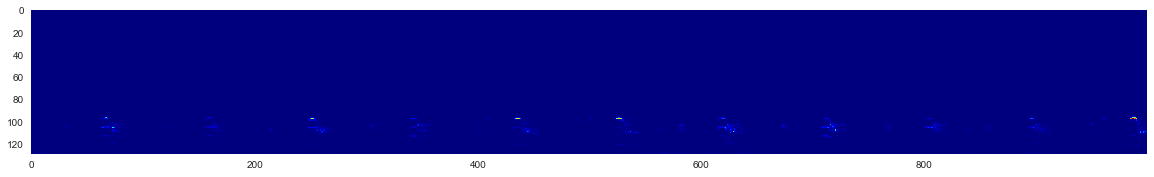

In [368]:
# Read bird song file
fs, sound_combined = scipy.io.wavfile.read('./songs_50_test_bird_0.15s.wav')
sound_combined = sound_combined[:,0]
f,t,spectrogram = scipy.signal.spectrogram(sound_combined, fs)
plt.figure(figsize=(20,20))
plt.imshow(np.flipud(spectrogram)[:,:1000], cmap='jet');
plt.grid(False)

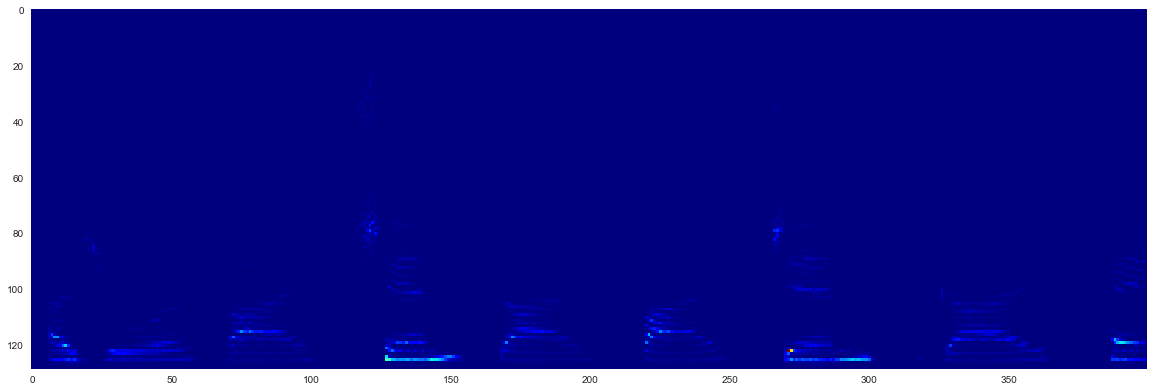

In [372]:
# Read the American English files
soundfiles = glob.glob('./American-English/*/*.wav')
sound_combined = np.zeros(0)
for file in soundfiles:
    fs, sound = scipy.io.wavfile.read(file)
    sound_combined = np.concatenate((sound_combined, sound))

f,t,spectrogram = scipy.signal.spectrogram(sound_combined, fs)
plt.figure(figsize=(20,20))
plt.imshow(np.flipud(spectrogram)[:,:400], cmap='jet');
plt.grid(False)

In [335]:
# Segment into overlapping segments
segment_len = 20 #samples
segment_step = 5 #samples
segments_lst = []
for t_start in np.arange(0, len(t) - segment_len, segment_step):
    segments_lst.append(spectrogram[:,t_start:(t_start + segment_len)])
    
# Do pca on each segment
X = np.zeros((segments_lst[0].shape[0] * segments_lst[0].shape[1], len(segments_lst)))
for idx, segment in enumerate(segments_lst):
    X[:,idx] = segment.ravel()
# Perform pca with whitening
pca = PCA(n_components=200, whiten=True)
pca.fit(X.T)
Y = pca.transform(X.T).T


In [336]:
Y.shape

(200, 918)

In [324]:
comp.shape

(200, 2580)

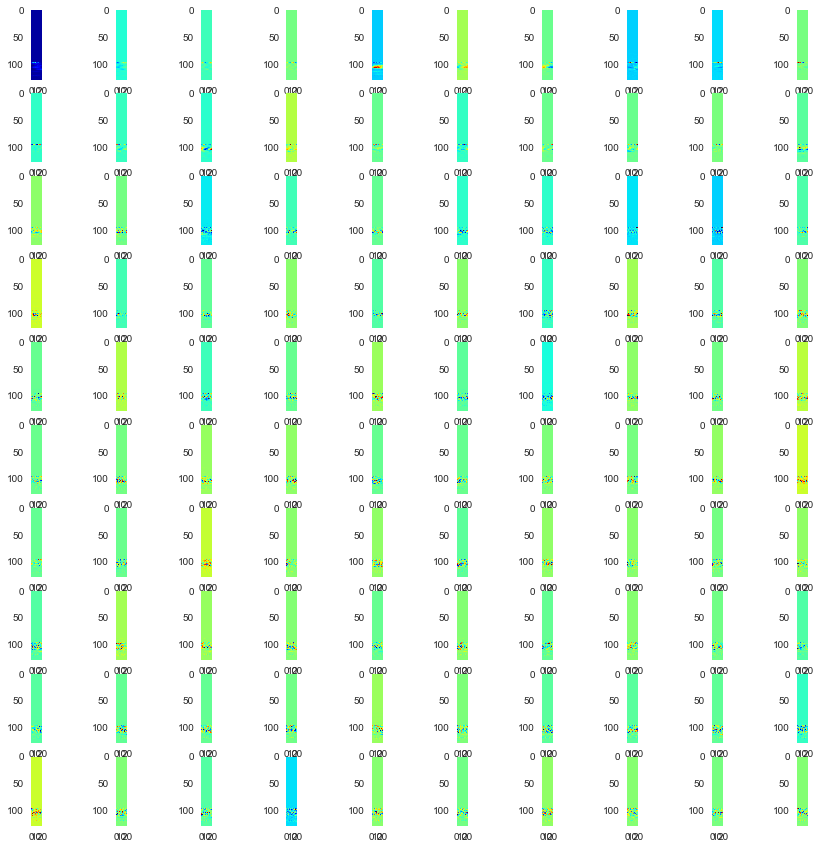

In [382]:
# Visualize principal components
fig, ax = plt.subplots(10, 10, figsize=(15,15))
comp = pca.components_
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
for i in range(10):
    for j in range(10):
        component = comp[10*i + j,:].reshape((129, 20))
        ax[i][j].grid(False)
        ax[i][j].imshow(np.flipud(component), cmap='jet')

## Start the learning

In [373]:
# Set learning parameters
iters = 10
nfeats = 800
lamb = 0.1
A = np.random.rand(comp.shape[0], nfeats)
A /= np.linalg.norm(A, axis=0)
s_lst = []
A_lst = []
tau = 0.1
eta = 0.001
theta = 0

In [390]:
tau = 0.1
for i in range(10):
    print('#### Finding s, iteration ', i, '####')
    s = find_s_batch(tau, A, Y, lamb, niter=3, verbose=False)
    print('#### Finding A, iteration ', i, '####')

    A = do_multiple_learn_steps(Y, A, s, eta=0.01, theta=0, nsteps=10, verbose=False)
    A /= np.linalg.norm(A, axis=0)

#### Finding s, iteration  0 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Best cost =  18404.3434911
#### Finding A, iteration  0 ####
Best cost =  5383.04867586
#### Finding s, iteration  1 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Best cost =  18400.0989348
#### Finding A, iteration  1 ####
Best cost =  5384.01504322
#### Finding s, iteration  2 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Best cost =  18399.4266054
#### Finding A, iteration  2 ####
Best cost =  5383.15354397
#### Finding s, iteration  3 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Best cost =  18396.330578
#### Finding A, iteration  3 ####
Best cost =  5386.47925864
#### Finding s, iteration  4 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Best cost =  18396.0038337
#### Finding A, iteration  4 ####
Best cost =  

In [394]:
800*918

734400

In [392]:
np.sum(s>0)

60024

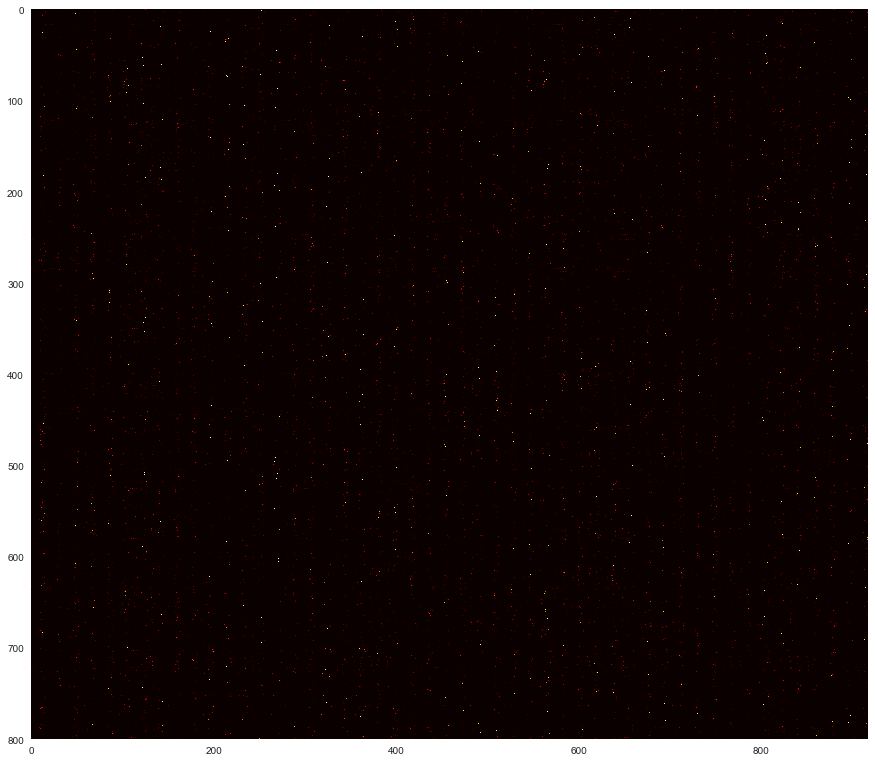

In [396]:
plt.figure(figsize=(15,15))
plt.imshow(s, cmap='hot')
plt.grid(False)

In [353]:
A.shape

(200, 800)

In [345]:
A2 = do_multiple_learn_steps(Y, A, s, eta=1, theta=0, nsteps=10, verbose=True)
A2 /= np.linalg.norm(A2, axis=0)

Cost =  167338.379768 eta =  1 theta =  0
Cost =  159075.40048 eta =  1.05 theta =  0.0
Cost =  154674.914876 eta =  1.1025 theta =  0.0
Cost =  153108.900037 eta =  1.1576250000000001 theta =  0.0
Cost =  155719.848777 eta =  1.2155062500000002 theta =  0.0
Cost =  145410.81751 eta =  0.6077531250000001 theta =  0.0
Cost =  143884.562852 eta =  0.6381407812500002 theta =  0.0
Cost =  142885.995263 eta =  0.6700478203125002 theta =  0.0
Cost =  141975.491266 eta =  0.7035502113281252 theta =  0.0
Cost =  141112.122608 eta =  0.7387277218945315 theta =  0.0
Best cost =  141112.122608 . Best A =  [[-0.27564025  2.12397717 -0.57662344 ...,  0.17536334 -0.42476787
   0.22015401]
 [-0.08089386 -0.01092427 -0.2073485  ..., -1.31382215  0.05476597
  -1.53650741]
 [ 0.22571322 -1.69623885  0.07169327 ...,  0.53192284 -0.20055426
   1.81165608]
 ..., 
 [ 3.09041526  0.27678833 -0.90247757 ..., -1.56056521  0.09065279
  -0.83108339]
 [ 1.40219993 -1.06509968 -0.4321302  ...,  1.50986221 -0.24852

Starting iteration # 0 ...
Cost =  67933.785845 . tau = 0.10500000000000001
Starting iteration # 1 ...
Cost =  60932.6756545 . tau = 0.11025000000000001
Starting iteration # 2 ...
Cost =  57647.3581581 . tau = 0.11576250000000002
Starting iteration # 3 ...
Cost =  55308.193794 . tau = 0.12155062500000002
Starting iteration # 4 ...
Cost =  53780.8432681 . tau = 0.12762815625000004
Starting iteration # 5 ...
Cost =  52605.5540219 . tau = 0.13400956406250006
Starting iteration # 6 ...
Cost =  51808.6670628 . tau = 0.14071004226562506
Starting iteration # 7 ...
Cost =  51034.2965033 . tau = 0.14774554437890633
Starting iteration # 8 ...
Cost =  50503.1214776 . tau = 0.15513282159785166
Starting iteration # 9 ...
Cost =  50033.7850389 . tau = 0.16288946267774426
Best cost =  50033.7850389


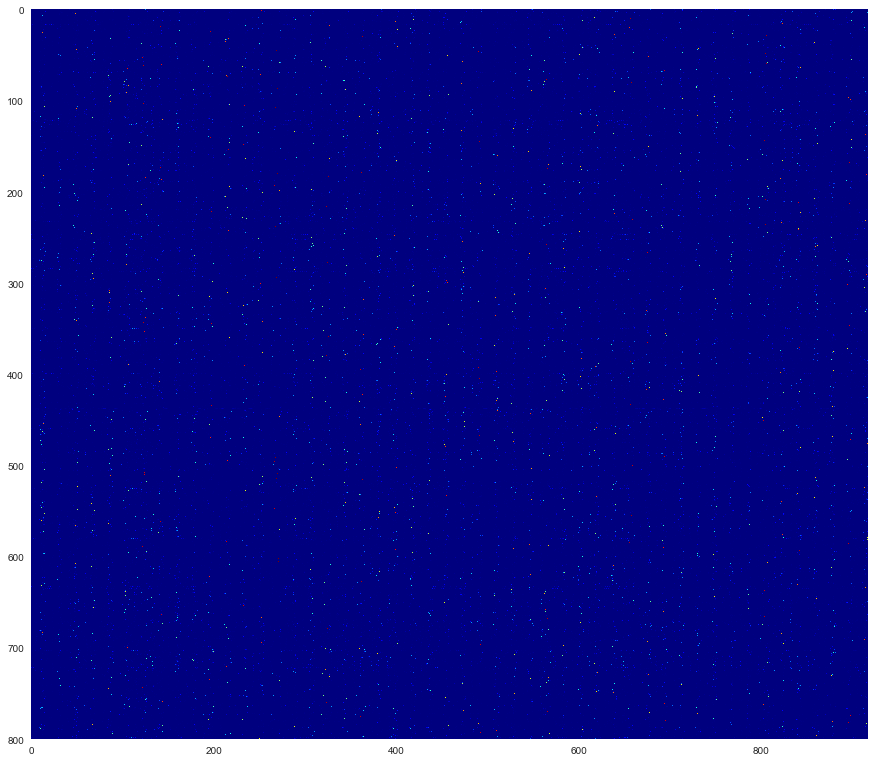

In [388]:
tau = 0.1
s2=find_s_batch(tau, A2, Y, lamb, niter=10, verbose=True)
plt.figure(figsize=(15,15))
plt.imshow(s, cmap='jet')
plt.grid(False)

In [ ]:
A2 = do_multiple_learn_steps

In [135]:
# Start learning
comp.shape
iters = 10
nfeats = 800
lamb = 0.000
A = np.random.rand(comp.shape[0], nfeats)
s_lst = []
A_lst = []
tau = 10

for i in range(10):
    print('Doing iteration #', i)
    # Pick a random training example
    #idx = np.random.randint(comp.shape[1])
    y = comp[:,i]
    
    # Find s
    s,_ = find_s(tau, A, y, lamb, niter=100, update='paper')
    s_lst.append(s)
    
    # Optimize A
    A = find_optimal_A(y, s)
    A_lst.append(A)
    

Doing iteration # 0
Best cost =  0.5 Best s = [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:38: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:38: RuntimeWarning: invalid value encountered in multiply
C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\numpy\lib\function_base.py:2652: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:33: RuntimeWarning: invalid value encountered in sign


Best cost =  inf Best s = [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0

Best cost =  inf Best s = [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0

Best cost =  inf Best s = [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0

In [38]:
x = A_lst[0].ravel()
y = x[x != 0]
y

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

In [234]:
Y

array([[ 30.,  20.],
       [ 49.,  10.],
       [ 79.,  60.]])

In [ ]:

s,_ = find_s(100000, A, y/100, lamb=100, niter=1000, update='direct')

#find_s(100000,A_lst[0], y, lamb, niter=100)

In [134]:
A = np.random.rand(comp.shape[0], nfeats)
y = comp[:,0]
#v, e = find_s(tau, A, y, lamb, niter=1000, update='paper')
s = np.array([3,3,4,5], dtype='float')
#y = np.array([30, 49, 79], dtype='float')
tau = 0.1
lamb = 0

y /= np.linalg.norm(y)

v, e = find_s(tau, A, y, lamb, niter=1000, update='paper')

Best cost =  0.499060593917 Best s = [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          

## Visualize the receptive fields of the neurons

In [438]:
plt.imshow?

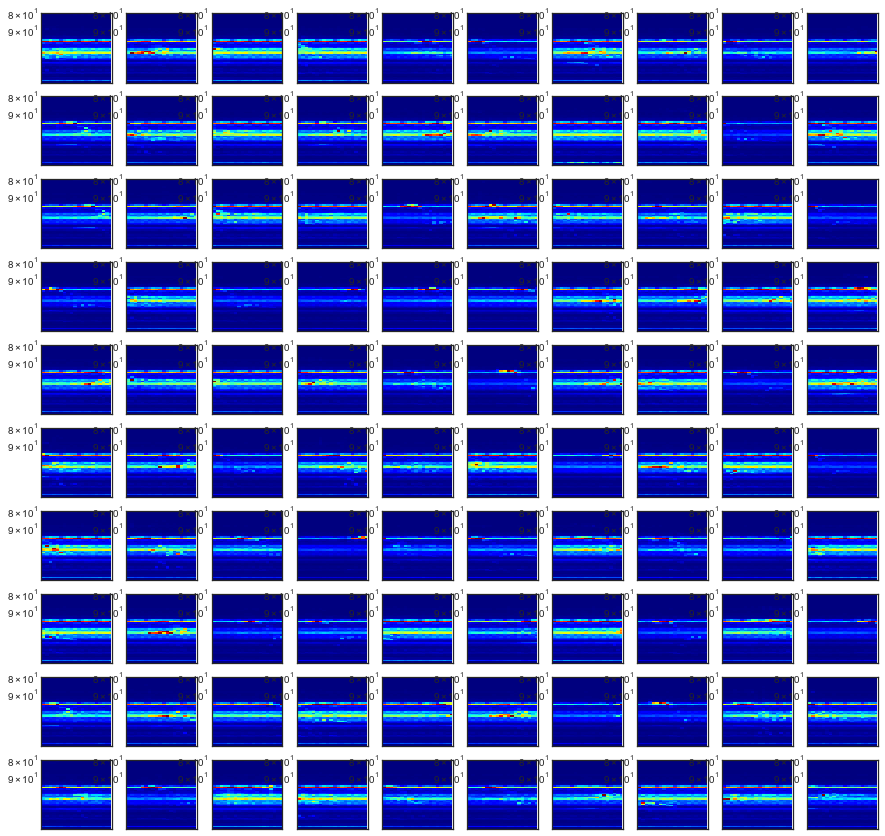

In [479]:
A_inverted = pca.inverse_transform(A.T)
with sns.axes_style('white'):
    fig, ax = plt.subplots(10, 10, figsize=(15,15))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=None)
    for i in range(10):
        for j in range(10):
            seg = A_inverted[10*i + j,:].reshape((129, 20))
            ax[i][j].imshow(np.flipud(seg), cmap='jet', aspect='auto')
            ax[i][j].grid(False)
            ax[i][j].set_yscale("log")
            ax[i][j].set_ylim([0, 80])
            ax[i][j].set(xticklabels=[], yticklabels=[])


(128.5, 80)

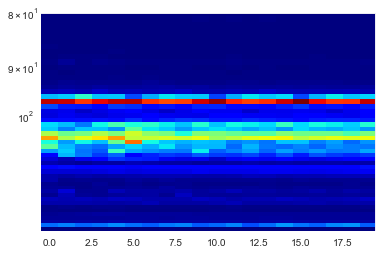

In [477]:
plt.imshow(np.flipud(seg), cmap='jet', aspect='auto')
plt.yscale('log')
plt.ylim([0, 80])

In [458]:
seg.shape

(129, 20)

In [ ]:
ax[0][0].set_yscale

In [ ]:
ax[i][j].set_yscale